## Cropping Craters
This script crops the crater propsals into 28x28 pixel images and saves them into directories. Also writes a csv file with metadata on each image as well as unique ID number.

In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import random
import string
%matplotlib inline

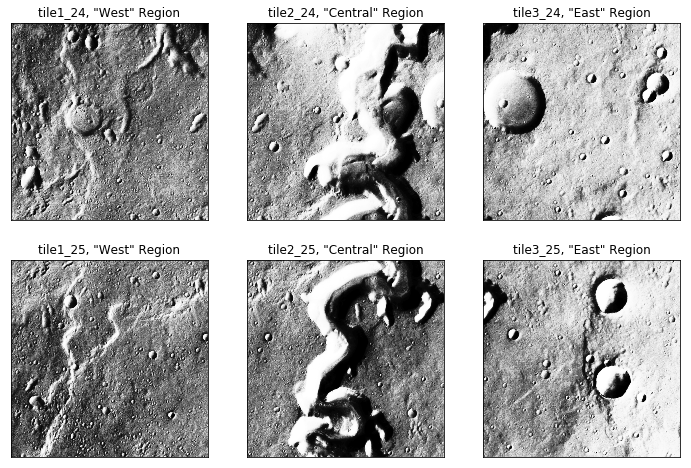

In [2]:
tile_names = [
    'tile1_24',
    'tile2_24',
    'tile3_24',
    'tile1_25',
    'tile2_25',
    'tile3_25',
]
regions = [
    '"West" Region',
    '"Central" Region',
    '"East" Region',
    '"West" Region',
    '"Central" Region',
    '"East" Region',
]

tiles = {}
for name in tile_names:
    num = name[4:]
    tiles[num] = PIL.Image.open(name + 's.pgm')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
axes = axes.reshape(6,)
for i, ax in enumerate(axes):
    ax.tick_params(
        axis='both', 
        which='both', 
        bottom='off', 
        top='off', 
        labelbottom='off', 
        right='off', 
        left='off', 
        labelleft='off'  # labels along the bottom edge are off
        )
    tile = tile_names[i][4:]
    ax.set_title(tile_names[i] + ', ' + regions[i])
    img = tiles[tile]
    ax.imshow(np.array(img), cmap='Greys')

In [3]:
true_proposals = pd.DataFrame(columns = ['x', 'y', 'd', 'tile'])
for tile in tile_names:
    num = tile[4:]
    new_proposals = pd.read_csv('./bandiera2010_candidates/{}_tp.csv'.format(num), header=None)
    new_proposals.columns = ['x', 'y', 'd']
    new_proposals.index = range(len(true_proposals), len(true_proposals)+len(new_proposals))
    new_proposals['tile'] = num
    true_proposals = pd.concat([true_proposals, new_proposals], axis=0)

In [4]:
false_proposals = pd.DataFrame(columns = ['x', 'y', 'd', 'tile'])
for tile in tile_names:
    num = tile[4:]
    new_proposals = pd.read_csv('./bandiera2010_candidates/{}_tn.csv'.format(num), header=None)
    new_proposals.columns = ['x', 'y', 'd']
    new_proposals.index = range(len(false_proposals), len(false_proposals)+len(new_proposals))
    new_proposals['tile'] = num
    false_proposals = pd.concat([false_proposals, new_proposals], axis=0)

In [5]:
def crop_crater(image, proposal):
    """Takes an input image of arbitrary size X, Y and a
    'crater', which is a tuplet (x, y, d) of a crater where
    x < X and y < Y. Returns a cropped image of dim 28x28 of
    the proposal.
    """
    x = proposal[0] #Record x and y positions
    y = proposal[1]
    r = max(14, proposal[2]) #"Radius" of image tbd
    #get four parameters of image box
    left = x - r
    upper = y - r
    right = x + r
    lower = y + r
    result = image.crop(box=(left, upper, right, lower))
    if result.size != (28, 28):
        result = result.resize((28, 28))
    return result

In [6]:
def random_id(K=5):
    """Returns a string of random characters (numeric and upper alpha)
    of length K"""
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(K))

In [7]:
true_proposals['crater'] = 1
false_proposals['crater'] = 0
proposals = pd.concat([true_proposals, false_proposals]).sample(frac=1)
proposals.index = range(len(proposals))
proposals['id'] = [random_id() for x in range(len(proposals))]

In [8]:
print('All random id numbers are unique: ', len(proposals['id'].unique()) == len(proposals))

All random id numbers are unique:  True


In [9]:
for index, proposal in proposals.iterrows():
    if proposal.crater == 1:
        classification = 'tp_images'
    if proposal.crater == 0:
        classification = 'fp_images'
    path = './{}/'.format(classification)
    filename = path + proposal['id'] + '.bmp'
    tile = tiles[proposal.tile]
    img = crop_crater(tile, (proposal[['x', 'y', 'd']]))
    img.save(filename)

In [10]:
proposals.to_csv('proposals.csv', index=False)